# Tabular Playground Series


**Work in progress**

- Still to do: fine-tune models and perform feature engineering 

In this notebook I will focus on tree methods (Random Forest, CatBoost, XGBoost), and I will also take a deep-dive in to Random Forest - elimination features that aren't above a self-defined importance threshold, and visualising how each individual feature combines to build the final prediction for an individual row.


**Overview**

Kaggle competitions are incredibly fun and rewarding, but they can also be intimidating for people who are relatively new in their data science journey. In the past, Kaggle have launched many Playground competitions that are more approachable than Featured competition, and thus more beginner-friendly.

The goal of these competitions is to provide a fun, but less challenging, tabular dataset. These competitions will be great for people looking for something in between the Titanic Getting Started competition and a Featured competition.

The dataset is used for this competition is synthetic but based on a real dataset and generated using a CTGAN. The original dataset deals with predicting the amount of an insurance claim. Although the features are anonymized, they have properties relating to real-world features.

**The data**

Train set has 300,000 rows while test set has 200,000 rows.
There are 19 categorical features from cat0 - cat18 and 11 continuous features from cont0 - cont10 with total of 30 features.



In [220]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/tabular-playground-series-mar-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-mar-2021/train.csv
/kaggle/input/tabular-playground-series-mar-2021/test.csv


# Importing the data


In [221]:
train_df = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2021/train.csv')
test_df = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2021/test.csv')
sub_df = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2021/sample_submission.csv')

test_df.head(3)

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10
0,5,A,F,A,A,F,BI,A,AH,AX,...,0.735690,0.578366,0.723154,0.228037,0.356227,0.551249,0.655693,0.598331,0.359987,0.947489
1,6,A,H,C,A,E,AB,I,F,N,...,0.313703,0.928885,0.516602,0.600169,0.795224,0.248987,0.654614,0.347944,0.565520,0.388580
2,8,A,N,C,A,F,AB,A,AH,BC,...,0.448201,0.424876,0.344729,0.242073,0.270632,0.746740,0.335590,0.341238,0.252289,0.411592


# Splitting the data between Continuous & Categorical Features

In [222]:
feature_cols = train_df.drop(['id', 'target'], axis=1).columns

## Split numeric & categoric data. Several ways to do this... 
numerical_columns = train_df[feature_cols].select_dtypes(include=['int64','float64']).columns
categorical_columns = train_df[feature_cols].select_dtypes(exclude=['int64','float64']).columns

## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_indexs = train_df.index
test_indexs = test_df.index

df =  pd.concat(objs=[train_df, test_df], axis=0).reset_index(drop=True)
df = df.drop(['id', 'target'], axis=1)
train_df

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
0,0,A,I,A,B,B,BI,A,S,Q,...,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,1,A,I,A,A,E,BI,K,W,AD,...,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0
2,2,A,K,A,A,E,BI,A,E,BM,...,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
3,3,A,K,A,C,E,BI,A,Y,AD,...,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0
4,4,A,I,G,B,E,BI,C,G,Q,...,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,499993,A,N,F,A,E,BU,A,AS,K,...,0.662428,0.671927,0.390566,0.145840,0.262767,0.514248,0.519340,0.617436,0.688007,0
299996,499995,A,K,A,A,G,BI,A,K,AE,...,0.821657,0.620356,0.384891,0.735879,0.547731,0.726653,0.470575,0.275743,0.638939,0
299997,499996,A,G,M,A,H,BI,C,L,F,...,0.407037,0.232436,0.832482,0.810663,0.596939,0.308821,0.373997,0.518024,0.452144,1
299998,499997,B,H,A,D,B,BI,A,AA,AX,...,0.808045,0.630708,0.346898,0.735147,0.563488,0.609836,0.680430,0.318453,0.335822,0


# Exploratory Data Analysis


We do see that some features have strong correlations in both the Train (left) & Test (right) datasets:

- Cont2 & Cont1 have a correlation of 0.9; this is very high
- Several other features are correlated strongly too

This is good for our model

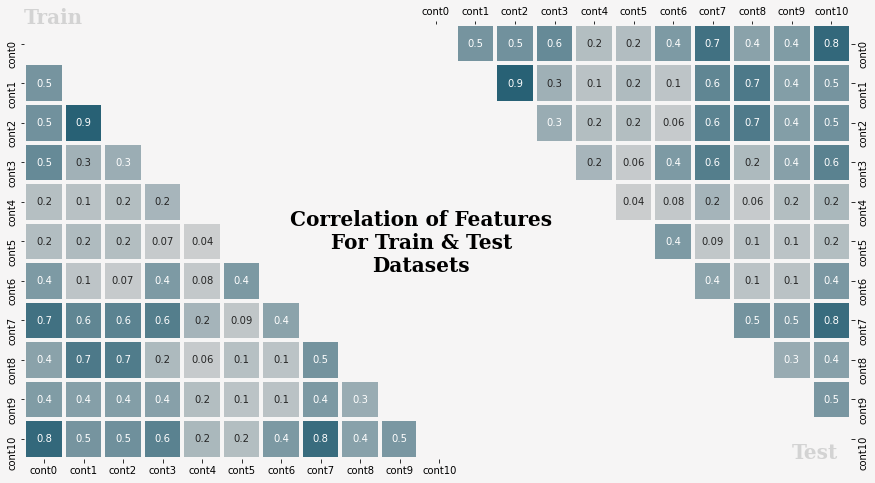

In [223]:
background_color = "#f6f5f5"

fig = plt.figure(figsize=(18, 8), facecolor=background_color)
gs = fig.add_gridspec(1, 2)
gs.update(wspace=-0.36, hspace=0.27)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
colors = ["#fbfbfb", "lightgray","#0e4f66"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

ax0.set_facecolor(background_color)
ax0.text(0, 0, 'Train', fontsize=20, fontweight='bold', fontfamily='serif',color='lightgray')

ax1.set_facecolor(background_color)
ax1.text(9.5, 11, 'Test', fontsize=20, fontweight='bold', fontfamily='serif',color='lightgray')


fig.text(0.5,0.5,'Correlation of Features\nFor Train & Test\nDatasets', fontsize=20, fontweight='bold', fontfamily='serif',va='center',ha='center')

corr = train_df[numerical_columns].corr().abs()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, ax=ax0, vmin=-1, vmax=1, annot=True, square=True, mask=mask,
            cbar_kws={"orientation": "horizontal"}, cbar=False, cmap=colormap, fmt='.1g',linewidth=3,linecolor=background_color)


corr = test_df[numerical_columns].corr().abs()
mask = np.tril(corr)
sns.heatmap(corr, ax=ax1, vmin=-1, vmax=1, annot=True, square=True, mask=mask,
            cbar_kws={"orientation": "horizontal"}, cbar=False, cmap=colormap, fmt='.1g',linewidth=3,linecolor=background_color)
ax1.xaxis.tick_top()
ax1.yaxis.tick_right()

plt.show()

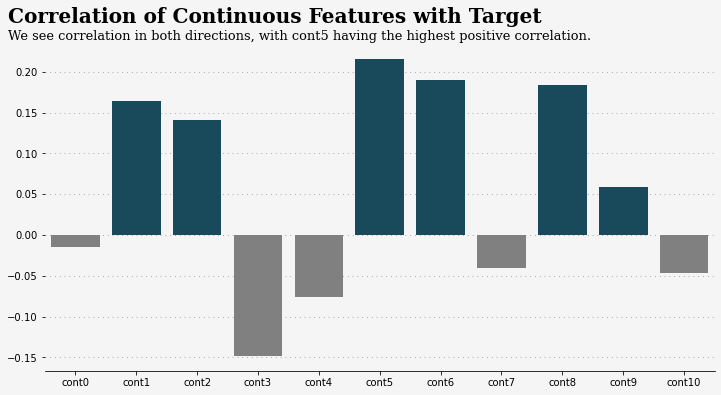

In [226]:
background_color = "#f6f5f5"

fig = plt.figure(figsize=(12, 6), facecolor=background_color)
gs = fig.add_gridspec(1, 1)
ax0 = fig.add_subplot(gs[0, 0])

ax0.set_facecolor(background_color)
ax0.text(-1.1, 0.26, 'Correlation of Continuous Features with Target', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-1.1, 0.24, 'We see correlation in both directions, with cont5 having the highest positive correlation.' ,fontsize=13, fontweight='light', fontfamily='serif')

chart_df = pd.DataFrame(train_df[numerical_columns].corrwith(train_df['target']))
chart_df.columns = ['corr']
chart_df['positive'] = chart_df['corr'] > 0

sns.barplot(x=chart_df.index, y=chart_df['corr'], ax=ax0, palette=chart_df.positive.map({True: '#0e4f66', False: 'gray'}), zorder=3,dodge=False)
ax0.grid(which='major', axis='y', zorder=0, color='gray', linestyle=':', dashes=(1,5))
ax0.set_ylabel('')


for s in ["top","right", 'left']:
    ax0.spines[s].set_visible(False)

plt.show()

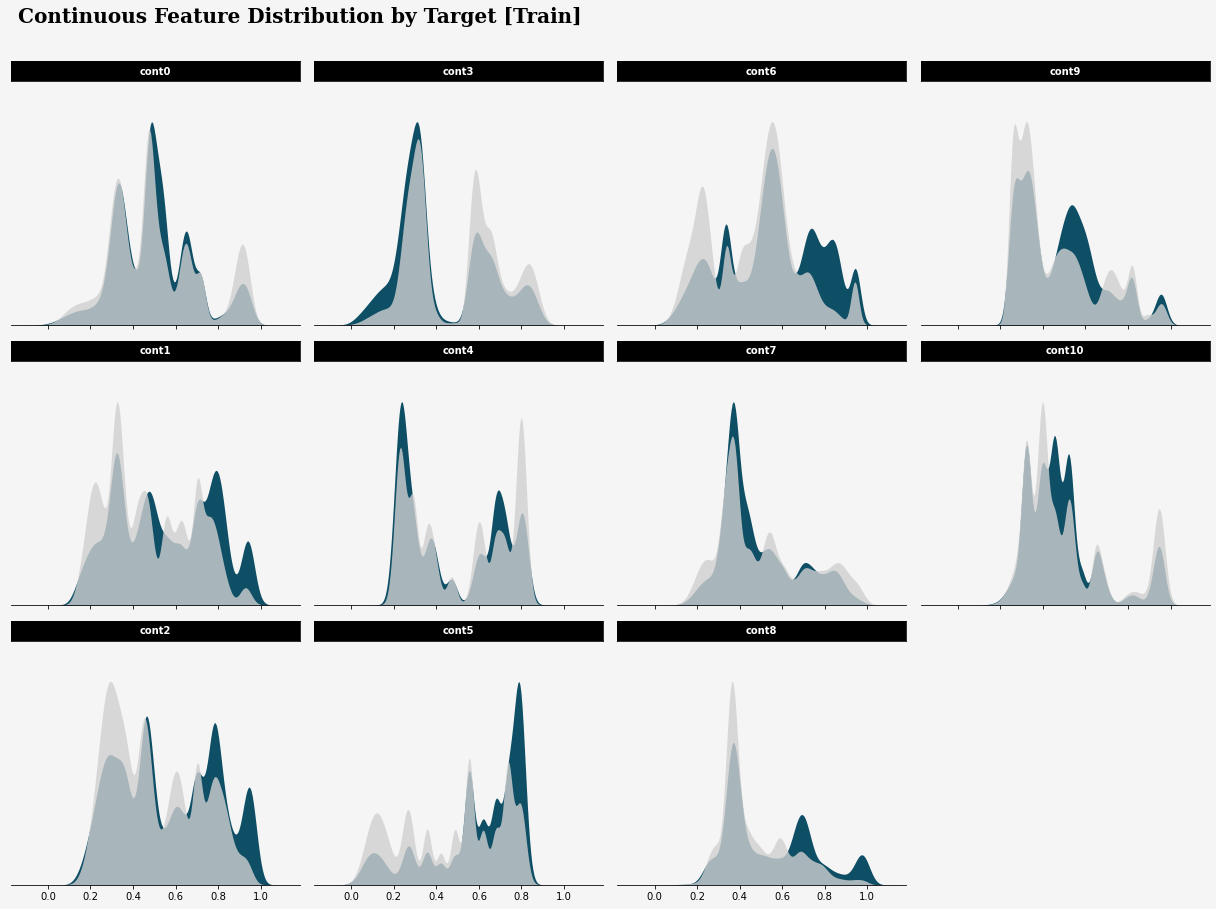

In [227]:
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(3, 4, figsize=(17, 12), sharex=True)
fig.set_facecolor('#f6f5f5') 

for i in range(11): 
    sns.kdeplot(data=train_df[train_df['target']==1], x=f'cont{i}', 
                fill=True,
                linewidth=0,
                color='#0e4f66', alpha=1,
                ax=ax[i%3][i//3])
    
    sns.kdeplot(data=train_df[train_df['target']==0], x=f'cont{i}', 
                fill=True,
                linewidth=0,
                color='#d0d0d0', alpha=0.8,
                ax=ax[i%3][i//3])
    
    ax[i%3][i//3].set_yticks([])
    ax[i%3][i//3].set_ylabel('',visible=False)
    ax[i%3][i//3].set_xlabel('',visible=False)
    ax[i%3][i//3].margins(0.05, 0.2)
    ax[i%3][i//3].set_facecolor(background_color) 
    for s in ["top","right", 'left']:
            ax[i%3][i//3].spines[s].set_visible(False)           
            
    # bar
    divider = make_axes_locatable(ax[i%3][i//3])
    cax = divider.append_axes("top", size="8%", pad=0)
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.set_facecolor('black')

    at = AnchoredText(f'cont{i}', loc=10, 
                      prop=dict(backgroundcolor='black',
                                size=10, color='white', weight='bold'))
    cax.add_artist(at)
    
ax[-1][-1].set_visible(False)
fig.text(0.018, 1.03, 'Continuous Feature Distribution by Target [Train]', fontsize=20, fontweight='bold', fontfamily='serif')

plt.tight_layout()
plt.show()

# Modelling

I will focus on tree methods. 

As a baseline, I will use a simple Random Forest Classifier, then progress to gradient boosting with CatBoost and XGBoost. 

Finally, I will use a soft Voting Classifier to see if the scores of each model individually can be improved.

In [179]:
# Various libraries I may or may not use...
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from category_encoders import CatBoostEncoder, LeaveOneOutEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score
from sklearn.svm import LinearSVC

# Data Preparation

In [180]:
# Encoding catergorical variables

for c in train_df.columns:
    if train_df[c].dtype=='object': 
        lbl = LabelEncoder()
        lbl.fit(list(train_df[c].values) + list(test_df[c].values))
        train_df[c] = lbl.transform(train_df[c].values)
        test_df[c] = lbl.transform(test_df[c].values)
        
display(train_df.head())




,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
0,0,0,8,0,1,1,33,0,44,54,...,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,1,0,8,0,0,4,33,8,48,3,...,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0
2,2,0,10,0,0,4,33,0,30,38,...,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
3,3,0,10,0,2,4,33,0,50,3,...,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0
4,4,0,8,6,1,4,33,2,32,54,...,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1


In [181]:
target = train_df.pop('target')
X_train, X_test, y_train, y_test = train_test_split(train_df, target, train_size=0.80)

# Random Forest Score: 0.88022

This is pretty good for our first model.

The benefits of a model such as this is that it is incredibly fast to train - an important attribute in industry.

In [182]:
# Simple Random Forest

rfc = RandomForestClassifier(n_estimators=300, max_depth=10, n_jobs=-1)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict_proba(X_test)[:, 1] # This grabs the positive class prediction
score = roc_auc_score(y_test, rfc_pred)
print(f'{score:0.5f}') # 0.873 shows we're doing better than a dummy model

0.87917


In [183]:
rf_df = pd.DataFrame(data=[roc_auc_score(y_test, rfc_pred)], 
             columns=['Random Forest Score'],
             index=["ROC AUC Score"])

# Diving deeper in to the Random Forest model interpretation

Let's look first at feature importance, and then at how a single record is effected by each variable by using a Waterfall Chart

In [184]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'Feature':df.columns, 'Importance':m.feature_importances_}
                       ).sort_values('Importance', ascending=False)




In [185]:
fi = rf_feat_importance(rfc, X_train)
fi[:10]



,Feature,Importance
17,cat16,0.260696
16,cat15,0.168656
19,cat18,0.110516
15,cat14,0.065792
25,cont5,0.044428
12,cat11,0.043191
3,cat2,0.038604
1,cat0,0.034877
18,cat17,0.033532
26,cont6,0.030274


# In industry, a simpler model is often better

This makes running the model faster, and the results easier to explain,

Let's now re-run the Random Forest model with only those feautures with an importance greater than 0.005



In [186]:
# Only keeping feautures with importance greater than 0.005
to_keep = fi[fi.Importance>0.005].Feature
len(to_keep)


23

In [187]:
X_train_imp  =  X_train[to_keep]
X_test_imp  = X_test[to_keep]

In [215]:
# Re-fitting with fewer variables
rfc = RandomForestClassifier(n_estimators=300, max_depth=10, n_jobs=-1)
rfc.fit(X_train_imp, y_train)
rfc_pred = rfc.predict_proba(X_test_imp)[:, 1] # This grabs the positive class prediction
score = roc_auc_score(y_test, rfc_pred)
print(f'{score:0.5f}') # 0.873 shows we're doing better than a dummy model

0.87832


A decent score, but with far few variables to study

In [189]:
len(X_train.columns), len(X_train_imp.columns)

(31, 23)

In [190]:
!pip install treeinterpreter
!pip install waterfallcharts

In [191]:
#hide
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

Prediction is simply the prediction that the random forest makes. bias is the prediction based on taking the mean of the dependent variable (i.e., the model that is the root of every tree). contributions is the most interesting bit—it tells us the total change in predicition due to each of the independent variables. Therefore, the sum of contributions plus bias must equal the prediction, for each row. Let's look just at the first row:

In [192]:

row =  X_test_imp.values[None,100] #This grabs the row we want to examine, row 100 chosen here
prediction, bias, contributions = treeinterpreter.predict(rfc, row)
prediction[0], bias[0]

(array([0.23472293, 0.76527707]), array([0.73569394, 0.26430606]))

In [193]:
contributions = [contributions[0][i][0] for i in range(len(contributions[0]))]

In [194]:
colnames = X_test_imp.columns[0:].values

# Waterfall Chart

Why is this useful?

Imagine a scenario where a business wants to know why a given prediciton has been made for a certain row or input. Instead of giving them the general feature importance, we can go one step further and actually show how the features indiviudual interact and produce the end-result

Source for the Waterfall visual:

https://github.com/chrispaulca/waterfall

Very informative, even more so for regression problems.

I haven't figured out true customization of this visual yet, so this is pretty much 'out-of-the-box'

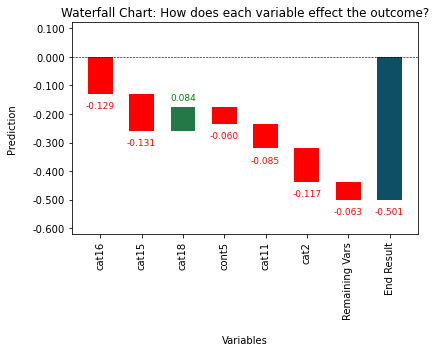

In [195]:
import waterfall_chart
my_plot=waterfall_chart.plot(colnames,contributions, rotation_value=90, threshold=0.3,formatting='{:,.3f}',net_label="End Result", other_label="Remaining Vars",
            Title="Waterfall Chart: How does each variable effect the outcome?", x_lab = "Variables", y_lab = "Prediction",green_color='#247747',blue_color='#0e4f66',red_color='#ff0000')



In [196]:
# Cross Val - took a long time with no benefit

#print(cross_val_score(rfc,X_train, y_train, scoring="roc_auc", cv = 5))
#mean_score = cross_val_score(rfc,X_train, y_train, scoring="roc_auc", cv = 5).mean()
#std_score = cross_val_score(rfc,X_train, y_train, scoring="roc_auc", cv = 5).std()

#print(mean_score)
#print(std_score)

# CatBoost scored even better: 0.89167

In [197]:
params = {'iterations': 5000,
         'learning_rate':0.013933182980403087,
          'reg_lambda': 47.79748127808107,
         'depth':5,
         'eval_metric':'AUC',
         'verbose':200,
         'od_type':'Iter',
         'od_wait':50}

In [198]:
cat_model = CatBoostClassifier(**params)
cat_model.fit(X_train,y_train)
cb_pred = cat_model.predict_proba(X_test)[:, 1] # This grabs the positive class prediction
score = roc_auc_score(y_test, cb_pred)
print(f'{score:0.5f}') # 0.873 shows we're doing better than a dummy model

0:	total: 64.2ms	remaining: 5m 21s
200:	total: 12s	remaining: 4m 46s
400:	total: 23.8s	remaining: 4m 32s
600:	total: 35.1s	remaining: 4m 17s
800:	total: 46.6s	remaining: 4m 4s
1000:	total: 58.5s	remaining: 3m 53s
1200:	total: 1m 9s	remaining: 3m 40s
1400:	total: 1m 21s	remaining: 3m 28s
1600:	total: 1m 33s	remaining: 3m 17s
1800:	total: 1m 44s	remaining: 3m 5s
2000:	total: 1m 55s	remaining: 2m 53s
2200:	total: 2m 7s	remaining: 2m 42s
2400:	total: 2m 18s	remaining: 2m 30s
2600:	total: 2m 30s	remaining: 2m 18s
2800:	total: 2m 41s	remaining: 2m 7s
3000:	total: 2m 53s	remaining: 1m 55s
3200:	total: 3m 4s	remaining: 1m 43s
3400:	total: 3m 16s	remaining: 1m 32s
3600:	total: 3m 27s	remaining: 1m 20s
3800:	total: 3m 39s	remaining: 1m 9s
4000:	total: 3m 51s	remaining: 57.7s
4200:	total: 4m 2s	remaining: 46.1s
4400:	total: 4m 14s	remaining: 34.6s
4600:	total: 4m 25s	remaining: 23.1s
4800:	total: 4m 37s	remaining: 11.5s
4999:	total: 4m 49s	remaining: 0us
0.89107


In [199]:
cb_df = pd.DataFrame(data=[roc_auc_score(y_test, cb_pred)], 
             columns=['CatBoost Score'],
             index=["ROC AUC Score"])

# XGBoost scored: 0.89167

Very similar to CatBoost. A good score, but as with CatBoost takes a while to train.

In [200]:
xgb = XGBClassifier(eval_metric="auc",
                          random_state=42,
                          tree_method="gpu_hist",
                          gpu_id="0",
                          use_label_encoder=False,verbose=200)


xgb_model = CatBoostClassifier(**params)
xgb_model.fit(X_train,y_train)
xgb_pred = xgb_model.predict_proba(X_test)[:, 1] # This grabs the positive class prediction
score = roc_auc_score(y_test, xgb_pred)
print(f'{score:0.5f}') # 0.873 shows we're doing better than a dummy model


0:	total: 60.3ms	remaining: 5m 1s
200:	total: 11.7s	remaining: 4m 39s
400:	total: 23.2s	remaining: 4m 26s
600:	total: 35.2s	remaining: 4m 17s
800:	total: 46.6s	remaining: 4m 4s
1000:	total: 57.9s	remaining: 3m 51s
1200:	total: 1m 9s	remaining: 3m 40s
1400:	total: 1m 21s	remaining: 3m 28s
1600:	total: 1m 32s	remaining: 3m 16s
1800:	total: 1m 44s	remaining: 3m 5s
2000:	total: 1m 55s	remaining: 2m 53s
2200:	total: 2m 7s	remaining: 2m 41s
2400:	total: 2m 18s	remaining: 2m 30s
2600:	total: 2m 30s	remaining: 2m 18s
2800:	total: 2m 41s	remaining: 2m 7s
3000:	total: 2m 53s	remaining: 1m 55s
3200:	total: 3m 5s	remaining: 1m 43s
3400:	total: 3m 16s	remaining: 1m 32s
3600:	total: 3m 28s	remaining: 1m 20s
3800:	total: 3m 39s	remaining: 1m 9s
4000:	total: 3m 51s	remaining: 57.8s
4200:	total: 4m 2s	remaining: 46.2s
4400:	total: 4m 14s	remaining: 34.6s
4600:	total: 4m 25s	remaining: 23.1s
4800:	total: 4m 37s	remaining: 11.5s
4999:	total: 4m 48s	remaining: 0us
0.89107


In [201]:
xgb_df = pd.DataFrame(data=[roc_auc_score(y_test, xgb_pred)], 
             columns=['XGBoost Score'],
             index=["ROC AUC Score"])

In [216]:
fi = rf_feat_importance(xgb_model, X_train)
xgb10_fi = fi[:10]

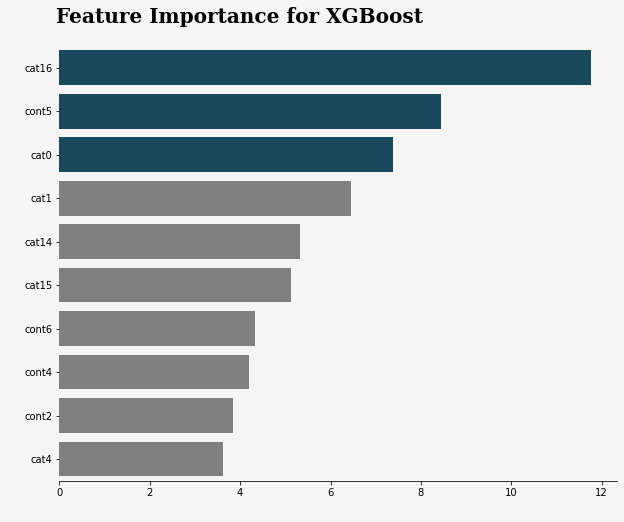

In [218]:
background_color = "#f6f5f5"

fig, ax = plt.subplots(1,1, figsize=(10, 8),facecolor=background_color)

color_map = ['gray' for _ in range(10)]
color_map[0] = color_map[1] = color_map[2] =  '#0e4f66' # color highlight

sns.barplot(data=xgb10_fi,x='Importance',y='Feature',ax=ax,palette=color_map)
ax.set_facecolor(background_color) 
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
    
fig.text(0.12,0.92,"Feature Importance for XGBoost", fontsize=20, fontweight='bold', fontfamily='serif')

    
plt.xlabel(" ", fontsize=12, fontweight='light', fontfamily='serif',loc='left',y=-1.5)
plt.ylabel(" ", fontsize=12, fontweight='light', fontfamily='serif')

plt.show()

# Voting Classifier: 88.957


Voting classifier takes all of the inputs and averages the results. 

For a "hard" voting classifier each classifier gets one vote, "yes"/1 or "no"/0, and the result is just a popular vote; you'll generally want odd numbers here so there is never a tie.

A "soft" classifier - the one I have opted for here - averages the confidence of each of the models. If a the average confidence is > 50% that it is a 1 it will be counted as such.

I'll combined the Random Forest, CatBoost, & XGBoost. 

In [204]:
voting_clf = VotingClassifier(estimators = [('rfc',rfc),('cat_model',cat_model),('xgb_model',xgb_model)], voting = 'soft') 

In [205]:
voting_clf.fit(X_train,y_train)
vc_pred = voting_clf.predict_proba(X_test)[:, 1] # This grabs the positive class prediction
score = roc_auc_score(y_test, vc_pred)
print(f'{score:0.5f}') # 0.873 shows we're doing better than a dummy model

0:	total: 63.3ms	remaining: 5m 16s
200:	total: 11.5s	remaining: 4m 35s
400:	total: 23.1s	remaining: 4m 24s
600:	total: 34.9s	remaining: 4m 15s
800:	total: 46.4s	remaining: 4m 3s
1000:	total: 58.1s	remaining: 3m 52s
1200:	total: 1m 9s	remaining: 3m 39s
1400:	total: 1m 20s	remaining: 3m 27s
1600:	total: 1m 32s	remaining: 3m 16s
1800:	total: 1m 44s	remaining: 3m 4s
2000:	total: 1m 55s	remaining: 2m 53s
2200:	total: 2m 7s	remaining: 2m 42s
2400:	total: 2m 19s	remaining: 2m 30s
2600:	total: 2m 30s	remaining: 2m 18s
2800:	total: 2m 42s	remaining: 2m 7s
3000:	total: 2m 53s	remaining: 1m 55s
3200:	total: 3m 5s	remaining: 1m 44s
3400:	total: 3m 16s	remaining: 1m 32s
3600:	total: 3m 27s	remaining: 1m 20s
3800:	total: 3m 39s	remaining: 1m 9s
4000:	total: 3m 51s	remaining: 57.7s
4200:	total: 4m 2s	remaining: 46.1s
4400:	total: 4m 14s	remaining: 34.6s
4600:	total: 4m 25s	remaining: 23.1s
4800:	total: 4m 37s	remaining: 11.5s
4999:	total: 4m 48s	remaining: 0us
0:	total: 61.1ms	remaining: 5m 5s
200:	t

In [206]:
vc_df = pd.DataFrame(data=[roc_auc_score(y_test, vc_pred)], 
             columns=['Voting Classifier Score'],
             index=["ROC AUC Score"])

# Results

I haven't tuned any of these models to find optimal parameters simply becasue it takes far too long on my computer. 

A simple GridSearch would likley improve these scores by a few points.


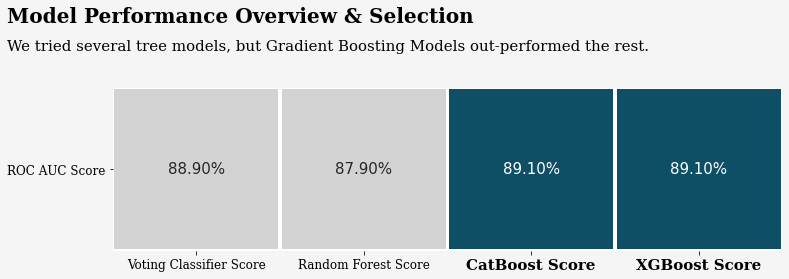

In [207]:
# Overall
colors = ["lightgray","#0e4f66"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
background_color = "#f6f5f5"


fig = plt.figure(figsize=(12,3), facecolor=background_color) # create figure
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])


df_models = round(pd.concat([vc_df,rf_df,cb_df,xgb_df], axis=1),3)
sns.heatmap(df_models, cmap=colormap,annot=True,fmt=".2%",vmax=0.891,vmin=0.89, linewidths=2.5,cbar=False,annot_kws={"fontsize":15})


ax0.text(-0.63,-0.4,'Model Performance Overview & Selection',fontfamily='serif',fontsize=20,fontweight='bold')
ax0.text(-0.63,-0.23,'We tried several tree models, but Gradient Boosting Models out-performed the rest.',fontfamily='serif',fontsize=15)



ax0.set_yticklabels(ax0.get_yticklabels(), fontfamily='serif', rotation = 0, fontsize=12)
ax0.set_xticklabels(ax0.get_xticklabels(), fontfamily='serif', rotation=0, fontsize=12)

for lab, annot in zip(ax0.get_xticklabels(), ax0.texts):
    text =  lab.get_text()
    if text == 'CatBoost Score': 
        # set the properties of the ticklabel
        lab.set_weight('bold')
        lab.set_size(15)
        lab.set_color('black')
        
for lab, annot in zip(ax0.get_xticklabels(), ax0.texts):
    text =  lab.get_text()
    if text == 'XGBoost Score': 
        # set the properties of the ticklabel
        lab.set_weight('bold')
        lab.set_size(15)
        lab.set_color('black')
        
from matplotlib.patches import Rectangle


#ax0.add_patch(Rectangle((0, 0), 2, 4, fill=True,color='#0e4f66', lw=0,alpha=0.5))

plt.show()

# Rather than Label Encoding, I'll try One-Hot Encoding

To explore whether or not how I encoded the categorical variables makes a difference to the ROC AUC score of our models.

In [208]:
#train_df = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2021/train.csv')
#test_df = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2021/test.csv')


#feature_cols = train_df.drop(['id', 'target'], axis=1).columns

## Split numeric & categoric data. Several ways to do this... 
#numerical_columns = train_df[feature_cols].select_dtypes(include=['int64','float64']).columns
#categorical_columns = train_df[feature_cols].select_dtypes(exclude=['int64','float64']).columns

## Join train and test datasets in order to obtain the same number of features during categorical conversion
#train_indexs = train_df.index
#test_indexs = test_df.index

#df =  pd.concat(objs=[train_df, test_df], axis=0).reset_index(drop=True)
#df = df.drop(['id', 'target'], axis=1)

#train_df = pd.read_csv('../input/tabular-playground-series-mar-2021/train.csv')
#test_df = pd.read_csv('../input/tabular-playground-series-mar-2021/test.csv')
#combine_df = pd.concat([train_df, test_df], axis=0)

#for col in categorical_columns:
#    combine_df[col] = pd.get_dummies(combine_df[col],drop_first=True)
#train_df = combine_df.iloc[:len(train_df), :]
#test_df = combine_df.iloc[len(train_df):, :]
#test_df = test_df.drop('target', axis=1)



In [209]:
#target = train_df.pop('target')
#X_train, X_test, y_train, y_test = train_test_split(train_df, target, train_size=0.80)

In [210]:
# Simple Random Forest

#rfc = RandomForestClassifier(n_estimators=200, max_depth=7, n_jobs=-1)
#rfc.fit(X_train, y_train)
#rfc_pred = rfc.predict_proba(X_test)[:, 1] # This grabs the positive class prediction
#score = roc_auc_score(y_test, rfc_pred)
#print(f'{score:0.5f}') # 0.873 shows we're doing better than a dummy model

In [211]:
#xgb = XGBClassifier(eval_metric="auc",
 #                         random_state=42,
  #                        tree_method="gpu_hist",
   #                       gpu_id="0",
    #                      use_label_encoder=False,verbose=200)


#xgb_model = CatBoostClassifier(**params)
#xgb_model.fit(X_train,y_train)
#xgb_pred = xgb_model.predict_proba(X_test)[:, 1] # This grabs the positive class prediction
#score = roc_auc_score(y_test, xgb_pred)
#print(f'{score:0.5f}') # 0.873 shows we're doing better than a dummy model

In [212]:
#cat_model = CatBoostClassifier(**params)
#cat_model.fit(X_train,y_train)
#cb_pred = cat_model.predict_proba(X_test)[:, 1] # This grabs the positive class prediction
#score = roc_auc_score(y_test, cb_pred)
#print(f'{score:0.5f}') # 0.873 shows we're doing better than a dummy model

# All models performed worse with One-Hot Encoding

# Conclusion

Without recourse to hyperparameter tuning, I am happy with the results I acheived. 

I will next try feature engineering as I do beleive we can acheive a better score with only a little extra effort.


We also took a deep-dive into Random Forest model interpretation - a useful skill for sure.

